In [1]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=20 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
#suff= ''
suff = '_corrected'

In [4]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape # subs *movies

(1049, 10)

In [5]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vidnames

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [6]:
from mne.stats import fdr_correction
from multipy.fdr import lsu
#from multipy.data import neuhaus

# "Social" v "Unsure" v "Non-social"


In [7]:
sub_id_all = np.load(os.path.join(data_file_loc,f'sub_id_all{suff}.npy'))
sub_id_all[143]

105620

In [8]:
responses.shape, suff

((1049, 10), '_corrected')


## Random Mech

In [9]:
movie_ind = 4
coef_slope_rand = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg',
f'coef_slopereg_runnorm_Random mechanical{suff}.npy'))

soc_inds = (responses[:,movie_ind]==1) #& (allresp == 1) # subs who responded "social"
nonsoc_inds = (responses[:,movie_ind]==0)  #& (allresp == 1) # subs who respoded "nonsocial"
unsure_inds = (responses[:,movie_ind]==9) #& (allresp == 1) # subs who respoded "unsure"

print(f'movie={vidnames[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])},unsure={len(np.where(unsure_inds)[0])}')

# ttest between slope regs yes vs. no
_,pval_slope_rand_S_NS = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_NS = lsu(pval_slope_rand_S_NS,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_NS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

# ttest between slope regs yes vs. unsure
_,pval_slope_rand_S_UNS_unc = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
pval_slope_rand_S_UNS = lsu(pval_slope_rand_S_UNS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_S_UNS = np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)

# ttest between slope regs unsure vs. no
_,pval_slope_rand_UNS_NS_unc = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
pval_slope_rand_UNS_NS = lsu(pval_slope_rand_UNS_NS_unc,q=.05)#fdr_correction(pval_slope_rand,.05)
meanDiff_sl_rand_UNS_NS = np.nanmean(coef_slope_rand[unsure_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)

_,pval_slope_rand_S_UNS_unc1 = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[unsure_inds,:],axis=0, equal_var=False)
_,pval_slope_rand_UNS_NS_unc1 = stats.ttest_ind(coef_slope_rand[unsure_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)

pval_slope_rand_UNS_NS_unc = pval_slope_rand_UNS_NS_unc<.05
pval_slope_rand_S_UNS_unc = pval_slope_rand_S_UNS_unc < .05

movie=Random mechanical,soc=107,nonsocial=670,unsure=225


In [10]:
100*(107+225)/670

49.55223880597015

In [11]:
# social>unsure and unsure>non-social or vice-versa, both corrected
nodes_rand_SUNS_UNSNS = (pval_slope_rand_S_UNS) & (pval_slope_rand_UNS_NS) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS:',len(np.where(nodes_rand_SUNS_UNSNS)[0])) # no sig  ndoes for RAND

#### same as above, unc.
# social>unsure and unsure>non-social or vice-versa, both uncorrected
nodes_rand_SUNS_UNSNS_unc = (pval_slope_rand_S_UNS_unc) & (pval_slope_rand_UNS_NS_unc) & (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) 
print('nodes_rand_SUNS_UNSNS_unc:',len(np.where(nodes_rand_SUNS_UNSNS_unc)[0])) # 5 sig nodes for RAND


nodes_rand_SUNS_UNSNS: 0
nodes_rand_SUNS_UNSNS_unc: 5


In [12]:
np.where(nodes_rand_SUNS_UNSNS_unc)[0]

array([  7,  13, 146, 148, 255])

- overall, 5 nodes show  S>unsure>NS at the uncorrected threshold for random mech


70

 # All MOVIES and ALL OTHER MOVIES S > Unsure >NS 

- for the all movies social v unsure v nonsocial analysis, we need trial-wise coeffts (the all movies analyses for the main results was from run-norm data where social and nonsocial were assigned positive and negative slopes - no way to correctly include unsure here - hence the need for trialwise reg coeffts) 

In [ ]:
# for comparison with the other main figure if needed
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
#nodes_randuns_all = nodes_coaxbill_rand_all & nodes_rand_SNS_SUNS
len(np.where(nodes_coaxbill_rand_all)[0])

In [15]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

814

In [16]:
#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm
import time
from datetime import datetime


In [17]:
responses.shape

(1049, 10)

In [18]:
# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((responses.shape[0],268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}{suff}.npy')
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

# ALL MOVIES    

In [20]:
coef_soc_uns_ALL, coef_uns_nonsoc_ALL= [np.empty((268,)) for _ in range(2)]
coef_soc_uns_ALL[:], coef_uns_nonsoc_ALL[:] = [np.nan]*2
pval_soc_uns_ALL, pval_uns_nonsoc_ALL = [np.empty((268,)) for _ in range(2)]
pval_soc_uns_ALL[:], pval_uns_nonsoc_ALL[:] = [np.nan]*2

In [21]:
# Yes v Unsure (ALL)
load_all = 0 # 1: load saved coefs, 0: run the LME
other_movies = [0,1,2,3,5,6,7,8,9] # do the analyses on all movies except rand mech
if load_all == 1:
     [coef_soc_uns_ALL,pval_soc_uns_ALL] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_unsure_ALLmovies.npy'), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in range(10):
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 0] # yes v unsure
        df['response'] = df['response'].map({1.0: "Social", 9.0:  "Unsure"})
        model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        model.fit(factors={"response":["Unsure","Social"]},summary = False, verbose = False)
        if n == 0:
            print('model:',model.fit(factors={"response":["Unsure","Social"]}))
        coef_soc_uns_ALL[n] = model.coefs['Estimate'][1]
        pval_soc_uns_ALL[n]= model.coefs['P-val'][1]
    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_unsure_ALLmovies.npy'), [coef_soc_uns_ALL,pval_soc_uns_ALL])
    print('Done on/at:',datetime.now()) # cell run at)

node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 4516	 Groups: {'subID': 814.0}

Log-likelihood: -5828.885 	 AIC: 11657.771

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.092  0.304
Residual               0.700  0.837

No random effect correlations specified

Fixed effects:

model:              Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.254   0.174    0.333  0.041  4300.459   6.245  0.000  ***
response1       0.131   0.050    0.212  0.041  4344.148   3.158  0.002   **
node 11,time=0.08 mins
node 21,time=0.14 mins
node 31,time=0.20 mins
node 41,time=0.26 mins
node 51,time=0.32 mins
node 61,time=0.39 mins
node 71,time=0.45 mins
node 81,time=0.52 mins
node 91,time=0.58 mins
node 101,time=0.64 mins
node 111,time=0.69 mins
node 121,time=0.75 mins
node 131,time=0.80 mins
node 141,time=0.86 mins
node 151,time=0.92 mins
node 161,time=0.97 mins
node 171,

In [22]:
# Unsure vs. Non-social
if load_all == 1:
     [coef_uns_nonsoc_ALL,pval_uns_nonsoc_ALL] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_unsure_v_nonsoc_ALLmovies.npy'), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in range(10): # MAKE SURE ALL 10 MOVIES ARE HERE
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 1] # no v unsure
            
        df['response'] = df['response'].map({0.0: "Non-social", 9.0:  "Unsure"})
        model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        model.fit(factors={"response":["Non-social","Unsure"]},summary = False, verbose = False)
        if n == 0:
            print(model.fit(factors={"response":["Non-social","Unsure"]}))
        #print('model 2:',model.fit())
        coef_uns_nonsoc_ALL[n] = model.coefs['Estimate'][1]
        pval_uns_nonsoc_ALL[n]= model.coefs['P-val'][1]
    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_unsure_v_nonsoc_ALLmovies.npy'),[coef_uns_nonsoc_ALL,pval_uns_nonsoc_ALL])
    print('Done on/at:',datetime.now()) # cell run at)

node 1,time=0.00 mins
Formula: coefs~response+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 4118	 Groups: {'subID': 814.0}

Log-likelihood: -4995.901 	 AIC: 9991.803

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.055  0.235
Residual               0.614  0.784

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.230   0.199     0.26  0.015   950.281  14.841   0.00  ***
response1       0.024  -0.053     0.10  0.039  4098.852   0.613   0.54     
node 11,time=0.07 mins
node 21,time=0.13 mins
node 31,time=0.18 mins
node 41,time=0.24 mins
node 51,time=0.29 mins
node 61,time=0.34 mins
node 71,time=0.39 mins
node 81,time=0.44 mins
node 91,time=0.51 mins
node 101,time=0.56 mins
node 111,time=0.62 mins
node 121,time=0.69 mins
node 131,time=0.75 mins
node 141,time=0.81 mins
node 151,time=0.87 mins
node 161,time=0.92 mins
node 171,time=0.9

Text(0.5, 0, 'Unsure>Non-social')

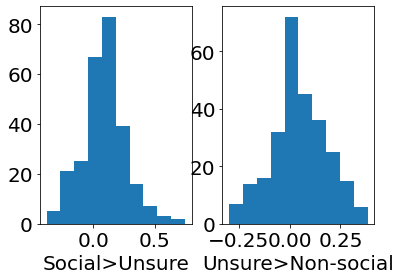

In [25]:
plt.subplot(121)
plt.hist(coef_soc_uns_ALL)
plt.xlabel('Social>Unsure')
plt.subplot(122)
plt.hist(coef_uns_nonsoc_ALL)
plt.xlabel('Unsure>Non-social')

In [27]:
coef_soc_uns_ALL[:10],pval_soc_uns_ALL[:10],coef_uns_nonsoc_ALL[:10],pval_uns_nonsoc_ALL[:10]

(array([ 0.1308141 ,  0.094797  ,  0.22516095, -0.00269409,  0.21522024,
         0.18724263, -0.09501009, -0.18874096,  0.04020703,  0.40818184]),
 array([1.60128759e-03, 1.77499823e-03, 2.84040825e-09, 9.34148741e-01,
        1.94052444e-06, 9.21394470e-05, 4.41073863e-02, 1.08184065e-04,
        3.81368051e-01, 7.51484457e-17]),
 array([ 0.02391684,  0.00800914, -0.1450852 ,  0.02845612, -0.15251492,
         0.02773625,  0.07170359,  0.13428545,  0.15140533,  0.14616338]),
 array([5.39956373e-01, 7.73510941e-01, 7.98078964e-05, 3.53195595e-01,
        1.20295468e-03, 5.57048897e-01, 1.17969499e-01, 4.86358544e-03,
        8.23351165e-04, 2.28866674e-03]))

In [29]:
# FDR-correct s>unsure and unsure >ns
pval_soc_uns_corr_ALL = lsu(pval_soc_uns_ALL,q=.05)
pval_uns_nonsoc_corr_ALL = lsu(pval_uns_nonsoc_ALL,q=.05)

pval_soc_uns_unc_ALL  = pval_soc_uns_ALL <.05
pval_uns_nonsoc_unc_ALL  = pval_uns_nonsoc_ALL <.05

# ALL EXCEPT (used in earlier versions of the MS draft)

In [63]:
load_allexcept = 1 # 1: load saved coefs, 0: run the LME

if load_allexcept ==0:    
    coef_soc_uns_ALLEXCEPT, coef_uns_nonsoc_ALLEXCEPT = [np.empty((268,)) for _ in range(2)]
    coef_soc_uns_ALLEXCEPT[:], coef_uns_nonsoc_ALLEXCEPT[:] = [np.nan]*2
    pval_soc_uns_ALLEXCEPT, pval_uns_nonsoc_ALLEXCEPT= [np.empty((268,)) for _ in range(2)]
    pval_soc_uns_ALLEXCEPT[:], pval_uns_nonsoc_ALLEXCEPT[:] = [np.nan]*2

In [64]:
# Yes v Unsure
other_movies = [0,1,2,3,5,6,7,8,9] # do the analyses on all movies except rand mech
if load_allexcept == 1:
     [coef_soc_uns_ALLEXCEPT,pval_soc_uns_ALLEXCEPT] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_unsure_othermovies.npy'), allow_pickle=True)
else:
    # initializing arrays

    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in other_movies:
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})

            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 0] # yes v unsure
        df['response'] = df['response'].map({1.0: "Social", 9.0:  "Unsure"})
        model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        model.fit(factors={"response":["Unsure","Social"]},summary = False, verbose = False)
        if n == 0:
            print('model:',model.fit(factors={"response":["Unsure","Social"]}))
        coef_soc_uns_ALLEXCEPT[n] = model.coefs['Estimate'][1]
        pval_soc_uns_ALLEXCEPT[n]= model.coefs['P-val'][1]

    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_unsure_othermovies.npy'), [coef_soc_uns_ALLEXCEPT,pval_soc_uns_ALLEXCEPT])
    print('Done on/at:',datetime.now()) # cell run at)

Text(0.5, 0, 'Social>Unsure')

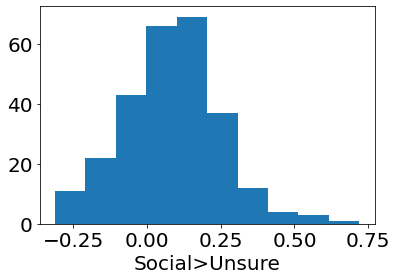

In [65]:
plt.hist(coef_soc_uns_ALLEXCEPT)
plt.xlabel('Social>Unsure')

In [67]:
# Unsure vs. Non-social
if load_allexcept == 1:
     [coef_uns_nonsoc_ALLEXCEPT,pval_uns_nonsoc_ALLEXCEPT] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_unsure_v_nonsoc_othermovies.npy'), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in other_movies:
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 1] # no v unsure
            
        df['response'] = df['response'].map({0.0: "Non-social", 9.0:  "Unsure"})
        model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        model.fit(factors={"response":["Non-social","Unsure"]},summary = False, verbose = False)
        if n == 0:
            print(model.fit(factors={"response":["Non-social","Unsure"]}))
        #print('model 2:',model.fit())
        coef_uns_nonsoc_ALLEXCEPT[n] = model.coefs['Estimate'][1]
        pval_uns_nonsoc_ALLEXCEPT[n]= model.coefs['P-val'][1]
    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_unsure_v_nonsoc_othermovies.npy'),[coef_uns_nonsoc_ALLEXCEPT,pval_uns_nonsoc_ALLEXCEPT])
    print('Done on/at:',datetime.now()) # cell run at)

In [68]:
coef_soc_uns_ALLEXCEPT[:10],pval_soc_uns_ALLEXCEPT[:10], coef_uns_nonsoc_ALLEXCEPT[:10],pval_uns_nonsoc_ALLEXCEPT[:10]

(array([ 0.14019538,  0.06923527,  0.1967056 , -0.02373897,  0.21174105,
         0.12633926, -0.10983152, -0.18081208,  0.01095707,  0.36324183]),
 array([5.75648571e-03, 6.20819467e-02, 2.30612494e-05, 5.52285120e-01,
        1.36402255e-04, 3.15224451e-02, 5.78959331e-02, 2.56704309e-03,
        8.46319351e-01, 1.32398485e-09]),
 array([ 0.00680107,  0.02456262, -0.12529581,  0.03409295, -0.15966885,
         0.07876587,  0.08611737,  0.12704457,  0.18609673,  0.17789179]),
 array([8.87449868e-01, 4.74264646e-01, 5.80135294e-03, 3.64530986e-01,
        6.27865420e-03, 1.76401056e-01, 1.28387935e-01, 3.19264794e-02,
        8.37076437e-04, 2.44267809e-03]))

In [56]:
# FDR-correct s>unsure and unsure >ns
pval_soc_uns_corr= lsu(pval_soc_uns_ALLEXCEPT,q=.05)
pval_uns_nonsoc_corr = lsu(pval_uns_nonsoc_ALLEXCEPT,q=.05)
pval_soc_uns_unc  = pval_soc_uns_ALLEXCEPT <.05
pval_uns_nonsoc_unc  = pval_uns_nonsoc_ALLEXCEPT <.05

In [61]:
# ALL EXCEPT social>unsure and unsure>non-social or vice-versa
# uncorrected
nodes_all_SUNS_UNSNS_unc_ALLEXCEPT = (pval_soc_uns_unc) & (pval_uns_nonsoc_unc) & \
(np.sign(coef_soc_uns_ALLEXCEPT) == np.sign(coef_uns_nonsoc_ALLEXCEPT))

#corrected
nodes_all_SUNS_UNSNS_ALLEXCEPT = (pval_soc_uns_corr) & (pval_uns_nonsoc_corr) & \
    (np.sign(coef_soc_uns_ALLEXCEPT) == np.sign(coef_uns_nonsoc_ALLEXCEPT)) 
print('all except:',len(np.where(nodes_all_SUNS_UNSNS_unc_ALLEXCEPT)[0]), len(np.where(nodes_all_SUNS_UNSNS_ALLEXCEPT)[0]))

all: 63 53
all except: 66 57


# ALL MOVIES further analysis (continue here)

In [33]:
# ALL social>unsure and unsure>non-social or vice-versa

# uncorrected
nodes_all_SUNS_UNSNS_unc_ALL = (pval_soc_uns_unc_ALL) & (pval_uns_nonsoc_unc_ALL) & \
(np.sign(coef_soc_uns_ALL) == np.sign(coef_uns_nonsoc_ALL))

#corrected
nodes_all_SUNS_UNSNS_ALL     = (pval_soc_uns_corr_ALL) & (pval_uns_nonsoc_corr_ALL) & \
    (np.sign(coef_soc_uns_ALL) == np.sign(coef_uns_nonsoc_ALL)) 

print('all:', len(np.where(nodes_all_SUNS_UNSNS_unc_ALL)[0]), len(np.where(nodes_all_SUNS_UNSNS_ALL)[0]))

all: 63 53


In [39]:
# nodes common to RANDOM MECH and ALL OTHER MOVIES
#common_nodes_soc_uns_nonsoc = [65,66,68,80,150]
#common_nodes_soc_uns_nonsoc 
common_nodes_soc_uns_nonsoc =  nodes_rand_SUNS_UNSNS_unc & nodes_all_SUNS_UNSNS_ALL # no intersection between all and rand thresholded
np.where(common_nodes_soc_uns_nonsoc)

(array([], dtype=int64),)

In [40]:
tr0_ind = 3 # ind at which tr=0 startsa
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
print(vid_start_rel_tr)
l_task = 28

[6 13 13 13 13 6 13 13 13 13]


In [55]:
def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):
    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan
    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1

#select subs who responded "social" to the yes movie and nonsocial to the no movie
print('\nrun-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm{suff}.npy') # load fmri data
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_run_z.shape)
tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind)
print('after:',tcs_run_z.shape)

# collapse across all movies except random  mech and runs (for timecourse plots)
tcs_run_resh_yes_allexceptR = []
tcs_run_resh_no_allexceptR  = []
tcs_run_resh_unsure_allexceptR  = []
subs_resh_yes_allexceptR  = []
subs_resh_no_allexceptR  = []
subs_resh_unsure_allexceptR  = []
for m in [0,1,2,3,5,6,7,8,9]: # no random mech
    tcs_run_resh_yes_allexceptR.append(tcs_run_z[responses[:,m]==1,:,:,m])# subsm * 268 * 31
    tcs_run_resh_no_allexceptR.append(tcs_run_z[responses[:,m]==0,:,:,m])# subsm * 268 * 31
    tcs_run_resh_unsure_allexceptR.append(tcs_run_z[responses[:,m]==9,:,:,m])# subsm * 268 * 31
    subs_resh_yes_allexceptR  += list(np.where(responses[:,m]==1)[0])# subsm * 268 * 31, keep track of subject seq
    subs_resh_no_allexceptR   += list(np.where(responses[:,m]==0)[0])# subsm * 268 * 31
    subs_resh_unsure_allexceptR  += list(np.where(responses[:,m]==9)[0])# subsm * 268 * 31
tcs_run_resh_yes_allexceptR  = np.concatenate(tcs_run_resh_yes_allexceptR ,axis=0)
tcs_run_resh_no_allexceptR   = np.concatenate(tcs_run_resh_no_allexceptR ,axis=0)
tcs_run_resh_unsure_allexceptR  = np.concatenate(tcs_run_resh_unsure_allexceptR ,axis=0)
print('Across all movies except random mech: \nyes:'+ str(tcs_run_resh_yes_allexceptR .shape) + ',\nno:' + str(tcs_run_resh_no_allexceptR .shape) + ',\nunsure:' + str(tcs_run_resh_unsure_allexceptR .shape))


run-wise norm data.
before: (1049, 268, 56, 10)
after: (1049, 268, 31, 10)
Across all movies except random mech: 
yes:(4849, 268, 31),
no:(3741, 268, 31),
unsure:(446, 268, 31)


In [56]:
# get a variable storing whether nodes show a difference in the end
soc_inds = (responses[:,movie_ind]==1) #& (allresp == 1) # subs who responded "social"
nonsoc_inds = (responses[:,movie_ind]==0)  #& (allresp == 1) # subs who respoded "nonsocial"
unsure_inds = (responses[:,movie_ind]==9) #& (allresp == 1) # subs who respoded "unsure"
pval_end_rand,    meandiff_end_rand, ntimepts_rand    = [np.empty((268,2)) for _ in range(3)]
pval_end_rand[:], meandiff_end_rand[:], ntimepts_rand[:] = [np.nan]*3
 
end_trs = 5
for n in range(268):# np.arange(10):
    
    tcn1 = np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[unsure_inds,n,-end_trs:,4],axis=1)
    #tcn1 = np.ndarray.flatten(tcs_run_z[soc_inds,   n,-2:,4])# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    #tcn2 = np.ndarray.flatten(tcs_run_z[unsure_inds,n,-2:,4])
    ntimepts_rand[n,0] =  np.sum(np.sign(np.nanmean(tcs_run_z[soc_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,0] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,0] = np.nanmean(tcn1) - np.nanmean(tcn2)
    
    tcn1 = np.nanmean(tcs_run_z[unsure_inds, n,-end_trs:,4],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_z[nonsoc_inds, n,-end_trs:,4],axis=1)
    #tcn1 = np.ndarray.flatten(tcs_run_z[unsure_inds, n,-2:,4])# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    #tcn2 = np.ndarray.flatten(tcs_run_z[nonsoc_inds, n,-2:,4])
    ntimepts_rand[n,1] =  np.sum(np.sign(np.nanmean(tcs_run_z[unsure_inds,   n,-end_trs:,4],axis=0) - \
         np.nanmean(tcs_run_z[nonsoc_inds,   n,-end_trs:,4],axis=0)))
    
    _,pval_end_rand[n,1] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_rand[n,1] = np.nanmean(tcn1) - np.nanmean(tcn2)

In [57]:
end_diff_rand_s_uns_ns = (np.sign(meandiff_end_rand[:,0]) == np.sign(meandiff_end_rand[:,1])) & \
     (pval_end_rand[:,0] < .05) & (pval_end_rand[:,1] < .05)
np.where(end_diff_rand_s_uns_ns)[0] # nr. of nodes which show a significant end difference

array([], dtype=int64)

In [58]:
rand_nodes_nosig = (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meanDiff_sl_rand_UNS_NS)) & \
    (ntimepts_rand[:,0] == end_trs) & (ntimepts_rand[:,1] == end_trs) & \
    (np.sign(meandiff_end_rand[:,0]) == np.sign(meandiff_end_rand[:,1]))  & \
    (np.sign(meanDiff_sl_rand_S_UNS) == np.sign(meandiff_end_rand[:,0])) 
np.where(rand_nodes_nosig)[0].shape
#((meandiff_end_rand[:,0]/meandiff_end_rand[:,1]) < 5 ) &
#((meandiff_end_rand[:,0]/meandiff_end_rand[:,1]) > 0.2) & 

(38,)

In [59]:
# get a variable storing whether nodes show a difference in the end
#if load ==0:

pval_end_allexcept,    meandiff_end_allexcept, ntimepts_allexcept = [np.empty((268,2)) for _ in range(3)]
pval_end_allexcept[:], meandiff_end_allexcept[:], ntimepts_allexcept[:] = [np.nan]*3

for n in range(268):# np.arange(10):
    
    tcn1 = np.nanmean(tcs_run_resh_yes_allexceptR[:,   n,-end_trs:],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_resh_unsure_allexceptR[:,n,-end_trs:],axis=1)
    
    _,pval_end_allexcept[n,0] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_allexcept[n,0] = np.nanmean(tcn1) - np.nanmean(tcn2)
    ntimepts_allexcept[n,0] =  np.sum(np.sign(np.nanmean(tcs_run_resh_yes_allexceptR[:,   n,-end_trs:],axis=0) - \
         np.nanmean(tcs_run_resh_unsure_allexceptR[:,   n,-end_trs:],axis=0)))
    
    tcn1 = np.nanmean(tcs_run_resh_unsure_allexceptR[:, n,-end_trs:],axis=1)# subs * t:end (if it's the onset of a divergence, there will be a difference in the end too)
    tcn2 = np.nanmean(tcs_run_resh_no_allexceptR[:,     n,-end_trs:],axis=1)
    ntimepts_allexcept[n,1] =  np.sum(np.sign(np.nanmean(tcs_run_resh_unsure_allexceptR[:,   n,-end_trs:],axis=0) - \
         np.nanmean(tcs_run_resh_no_allexceptR[:,   n,-end_trs:],axis=0)))
    
    _,pval_end_allexcept[n,1] = stats.ttest_ind(tcn1,tcn2,nan_policy='omit', equal_var= False)
    meandiff_end_allexcept[n,1] = np.nanmean(tcn1) - np.nanmean(tcn2)

In [69]:
all_except_nosig = (np.sign(coef_soc_uns_ALLEXCEPT) == np.sign(coef_uns_nonsoc_ALLEXCEPT)) &\
    (np.sign(meandiff_end_allexcept[:,0]) == np.sign(meandiff_end_allexcept[:,1]))  & \
    (np.sign(coef_soc_uns_ALLEXCEPT) == np.sign(meandiff_end_allexcept[:,0])) & \
    (ntimepts_allexcept[:,0] == end_trs) & (ntimepts_allexcept[:,1] == end_trs)
    
np.where(all_except_nosig)[0].shape

(36,)

In [280]:
#all_betas_pos = np.load(os.path.join(data_file_loc,'glm_intersecting_nodes_allbetaspos.npy'))
#all_betas_pos.shape,type(all_betas_pos)

In [71]:
common_nodes_soc_uns_nonsoc_nosig_ALLEXCEPT =  nodes_all_SUNS_UNSNS_ALLEXCEPT  & rand_nodes_nosig  & all_except_nosig & \
    (np.sign(coef_soc_uns_ALLEXCEPT) == np.sign(meanDiff_sl_rand_S_UNS)) & \
    (nodes_coaxbill_rand_all) # nodes_all_SUNS_UNSNS & rand_nodes_nosig \ in the original v
np.where(common_nodes_soc_uns_nonsoc_nosig_ALLEXCEPT)[0],np.where(common_nodes_soc_uns_nonsoc_nosig_ALLEXCEPT)[0].shape

NameError: name 'nodes_all_SUNS_UNSNS_ALLEXCEPT' is not defined

In [77]:
# new cell added in Aug 7, 2022
common_nodes_soc_uns_nonsoc_nosig_ALL =  nodes_all_SUNS_UNSNS_ALL  & rand_nodes_nosig  & all_except_nosig & \
    (np.sign(coef_soc_uns_ALL) == np.sign(meanDiff_sl_rand_S_UNS)) & \
    (nodes_coaxbill_rand_all) # nodes_all_SUNS_UNSNS & rand_nodes_nosig \ in the original v
np.where(common_nodes_soc_uns_nonsoc_nosig_ALL)[0],np.where(common_nodes_soc_uns_nonsoc_nosig_ALL)[0].shape

(array([ 15,  21,  68,  70, 150, 213, 252]), (7,))

In [45]:
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.6...","{'coords': [9.599999999999994, 17.618823529411...","{'coords': [5.270633397312864, 35.032629558541...","{'coords': [15.647840531561457, 34.18604651162...","{'coords': [8.283887468030684, 46.058823529411...","{'coords': [14.581460674157299, 64.75280898876...","{'coords': [30.41914191419142, 54.795379537953...","{'coords': [44.469325153374236, 46.09509202453...","{'coords': [28.814814814814817, 51.16316316316...","{'coords': [8.521081081081078, 53.28, 23.88540...",...,"{'coords': [-10.399527186761233, 10.8770685579...","{'coords': [-14.491582491582491, -3.5488215488...","{'coords': [-24.77079107505071, 5.537525354969...","{'coords': [-9.427230046948353, -25.5399061032...","{'coords': [-4.68474576271187, -10.24067796610...","{'coords': [-11.407792207792212, -25.563636363...","{'coords': [-4.821052631578951, -21.5115789473...","{'coords': [-4.227272727272734, -37.8977272727...","{'coords': [-6.9375, -33.13068181818181, -39.3...","{'coords': [-5.697885196374628, -18.9667673716..."


# Plot stuff

In [46]:
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_glass_brain, plot_surf_roi,plot_stat_map,plot_img,plot_surf_contours
import nibabel as nib
from nilearn import datasets
bg_img = datasets.load_mni152_template()


from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from nilearn import datasets
bg_img = datasets.load_mni152_template()

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain


mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [ ]:

fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')


## Plot timecourses (not run yet, aug 7)

In [283]:
# get the right red/blue shades
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
'''green_rgb = np.nanmean(np.array([red_rgb,blue_rgb]),axis=0)
green_rgb'''
alpha = .2 # transparency inside boxplots, for datapts etc.

In [285]:
TR=.72
tr0_ind = 3

In [286]:
ns = np.where(nodes_all_SUNS_UNSNS_ALLEXCEPT)[0]
ls = list((coef_soc_uns+coef_uns_nonsoc)/2)
inds = sorted(range(len(ls)), key=lambda k: ls[k]) 
inds_highest_mean = inds[::-1][:10]

In [287]:
## Save ROIs

#import plotting functions

cols = ['k','k','g']
lw = [3,2,1]

lbl = [str.upper(x[0:4]) for x in vidnames]
lbl


['COAX',
 'BILL',
 'DRIF',
 'FISH',
 'RAND',
 'SCAR',
 'SEDU',
 'STAR',
 'SURP',
 'TENN']

In [352]:
nodes_ind = np.where(common_nodes_soc_uns_nonsoc_nosig)[0]
df = pd.DataFrame({'Node_ind(0-267)': nodes_ind,
                    'MNIy':[eval(shen268_lbl[str(n+1)][0])['coords'][1] for n in nodes_ind],
                    'coef_soc_uns':coef_soc_uns[nodes_ind],'coef_uns_nonsoc':coef_uns_nonsoc[nodes_ind] })
df['mean_coef'] = df.loc[:,['coef_soc_uns','coef_uns_nonsoc']].mean(axis=1)
#df.sort_values(by = ['mean_coef'],inplace=True, ascending=False)
df.sort_values(by = ['MNIy'],inplace=True)
df.reset_index(inplace=True)
df.shape

(7, 6)

In [353]:
nodes_ind = df['Node_ind(0-267)'].values
nodes_ind

array([213, 252,  68,  70,  21,  15, 150])

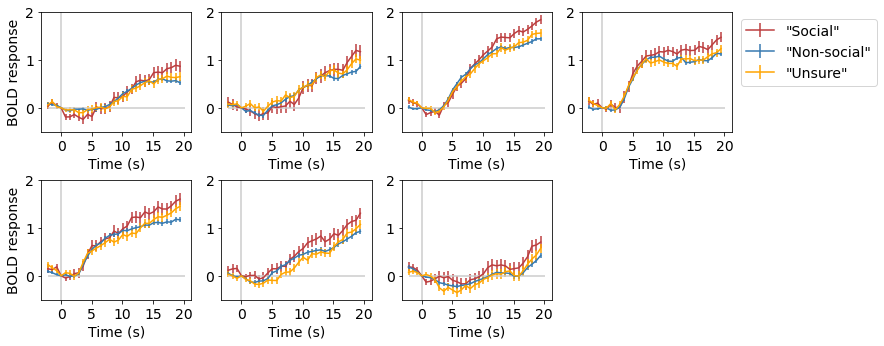

In [354]:
# plot timecourses of common nodes
# final plot, but not used in manuscript
# need to see if nodes from all or all except were used!! (as of Aug 7, 2022)

[ymin,ymax] = [-.5,2]
xlbls = [0,5,10,15,20]
x_ticks = [(i/TR)+tr0_ind for i in xlbls]
xlbls = [str(i) for i in xlbls]
ncols = 4
nrows = int(np.ceil(nodes_ind.shape[0]/ncols))
#line_loc = []
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex=False, 
sharey=False, figsize = (12,4)) # figsize = (20,15))
#plt.suptitle('Left hemisphere', fontweight='bold')  

for i,n in enumerate(nodes_ind): #for i,n in enumerate(df['Nodes']):
     #fig, ax = plt.figure(i+1,figsize=(10,5))   
     
     if ncols == 1:
          ax1 = ax[i]
     else:
          r = int(np.floor(i/ncols))
          c = int(i % ncols)
          ax1 = ax[r,c]

     movieTC_yes = tcs_run_z[responses[:,4]==1,n,:,4] # nsubs * ntimepts
     movieTC_no  = tcs_run_z[responses[:,4]==0,n,:,4] # nsubs * ntimepts
     movieTC_unsure  = tcs_run_z[responses[:,4]==9,n,:,4] # nsubs * ntimepts
     
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_yes,axis=0),stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = red_rgb,linewidth=1.5,label ='"Social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_no,axis=0),stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = blue_rgb,linewidth=1.5,label ='"Non-social"')
     ax1.errorbar(range(movieTC_yes.shape[1]),np.nanmean(movieTC_unsure,axis=0),stats.sem(movieTC_unsure,axis=0,nan_policy='omit'),color = 'orange',linewidth=1.5,label ='"Unsure"')
     ax1.vlines(tr0_ind,-1,2,color=[.8,.8,.8])
     ax1.hlines(0,0,31,color=[.8,.8,.8])
     ax1.set_ylim(ymin,ymax)
     #ax1.set_title(f'Node {n+1}',fontweight = 'bold')
     ax1.set_xticks(x_ticks)
     ax1.set_xticklabels(xlbls, fontsize=14)
     ax1.set_yticks([0,1,2])
     ax1.set_yticklabels([i for i in [0,1,2]],fontsize=14)
     
     #ax[r,0].set_ylabel('BOLD\n(a.u.)')
     #txt = '\n'.join(eval(shen268_lbl[str(n+1)][0])['name'].split(';'))
     #ax1.text(35,0,txt)
     if  (c==0):
          ax1.set_ylabel('BOLD response', fontsize=14 )
     #if r == nrows-1:
     ax1.set_xlabel('Time (s)', fontsize=14 )
     if (r==0) and (c==ncols-1):
          ax1.legend(bbox_to_anchor = [1.01,1],fontsize=14 )

     MNIz = eval(shen268_lbl[str(n+1)][0])['coords'][2]
     #ax1.annotate(f'z={int(np.round(MNIz))}',xy=(0,.7), xycoords='axes fraction',size = 12)
    
if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(nodes_ind)[0]))):
          ax[r,c+1+i].axis('off')
#plt.tight_layout()
plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.2, 
                        hspace=.4)
plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs_tc{suff}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')

In [355]:
# save axial plots of each roi
# TAKES TIME, RUN ONLY IF NECESSARY!

start_time = time.time()
fig,axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (9,3))
for i,n in enumerate(nodes_ind): #for i,n in enumerate(df['Nodes']):
    print(i, np.round((time.time()-start_time)/60))
    #ax = fig.add_subplot(nrows,1,i+1)
    r = int(np.floor(i/ncols))
    c = int(i%ncols)
    ax = axs[r,c]
    
    nodes = np.zeros((268,))
    nodes[n] = meanDiff_sl_rand_S_UNS[n]

    img = roi_to_brain(pd.Series(nodes), mask_x)
    '''zsl = row[1]['MNIz']
    if np.abs(zsl-zslices[0]) < np.abs(zsl-zslices[1]):
        zsl = zslices[0]
    else:
        zsl = zslices[1]'''
    MNIz = eval(shen268_lbl[str(n+1)][0])['coords'][2]
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',cut_coords =[MNIz],cmap = 'RdBu_r',bg_img = bg_img,colorbar= False, threshold = .001,\
    vmin = -.26,vmax=.26,axes =ax,figure=fig,annotate=False) # cmap = 'plasma'
    ax_plot.add_contours(color_rois((nodes)),linewidths=1, colors=['k'],linestyles='solid')
    #ymin,ymax = plt.ylim()
    #plt.ylim(ymin,10)
    #xmin,xmax = plt.xlim()
    #plt.xlim(xmin,10)

if ncols > 1:
     for i in range(int(nrows*ncols-len(np.where(nodes_ind)[0]))):
          axs[r,c+1+i].axis('off')
plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,f'common_nodes/social_unsure_nonsocial/all_ROIs{suff}.png'),dpi=300,bbox_inches='tight',facecolor='none', edgecolor='none')
plt.clf()

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 648x216 with 0 Axes>

# Plot brainmaps

In [47]:
#fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/')
#coords = [np.round(eval(shen268_lbl[str(n+1)][0])['coords'][2]) for n in np.where(common_nodes_soc_uns_nonsoc)[0]]
#coords
comp_lbls = ['Soc_Unsure','Unsure_Nonsoc']

In [69]:
import brain_plot_functions
from importlib import reload
reload(brain_plot_functions)
#try:
#    f
#    print('import successful!')
#except:
#    print('issue importing, using reload...')
    
# not run yet

In [71]:
def surf_plot1(fig,ax,nodes,params):

    title_txt = params['title']
    txt  = params['txt']
    vmin = params['vmin']
    vmax = params['vmax']
  
    #LH
    ax_surf = ax[0,0]
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc_nosig), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot1, legend=True,levels = [1], colors=['k'])
    
    ax_surf = ax[1,0]
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot2, legend=True,levels = [1], colors=['k'])

    #RH
    ax_surf = ax[0,1]
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    texture_contour = vol_to_surf(color_rois(common_nodes_soc_uns_nonsoc_nosig), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot3, legend=True,levels = [1], colors=['k'])

    surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    box = surf_plot3.axes[4].get_position()
    surf_plot3.axes[4].set_position([box.x0*.93, box.y0-.3, box.width, box.height*2])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    

    ax_surf = ax[1,1]
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes = ax_surf)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    
    v5_texture = vol_to_surf(v5_roi_nii,                          fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    thr99 = np.quantile(v5_texture,.99)
    v5_texture[v5_texture<thr99] = 0
    v5_texture[v5_texture!=0] = 1
    plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot3, legend=False, axes=ax[0,1],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])
    plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot4, legend=False, axes=ax[0,1],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])


    ax[0,0].dist = 7 # change viewing distance to "zoom in" to surface plots
    ax[0,1].dist = 7
    ax[1,0].dist = 7
    ax[1,1].dist = 7

    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.0, 
                        hspace=-.1)


In [75]:
# to highlight V5/MT if needed
# v5_roi = 'v5_association-test_z_FDR_0.01.nii'
# v5_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{v5_roi}'
# v5_roi_nii = nib.load(v5_roi_loc)

## (1) RAND MECH

In [ ]:
# surface plots
vmin,vmax = -.26,.26
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'RANDOM MECH'

for comp in range(2):

    nodes = np.zeros((268,))
    if comp == 0:
        #txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        
        nodes[rand_nodes_nosig] = meanDiff_sl_rand_S_UNS[rand_nodes_nosig]
    else:
        #txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        nodes[rand_nodes_nosig] = meanDiff_sl_rand_UNS_NS[rand_nodes_nosig]
    
    fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}

    surf_plot1(fig,ax,nodes,params)
    plt.savefig(os.path.join(fig_save_loc,f'RAND/surf_all4_{comp_lbls[comp]}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
    img = roi_to_brain(pd.Series(nodes), mask_x)
    #coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    #ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
    #ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    ax_plot.add_contours(color_rois(common_nodes_soc_uns_nonsoc_nosig),linewidths=1, colors=['k'],linestyles ='-',filled=False)
    #ax_plot.add_contours(color_rois(nodes_rand_SUNS_UNSNS_unc),linewidths=1, colors=['g'],linestyles ='-',filled=False)
    plt.savefig(os.path.join(fig_save_loc,f'RAND/{comp_lbls[comp]}_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
    #plt.clf()'''

In [385]:
[[n,eval(shen268_lbl[str(n+1)][0])['name']] for n in np.where(common_nodes_soc_uns_nonsoc_nosig)[0]]

[[15,
  '42.87% Inferior_Frontal_Gyrus_pars_triangularis; 25.98% Inferior_Frontal_Gyrus_pars_opercularis; 12.25% Frontal_Orbital_Cortex; 10.24% Frontal_Pole; 6.02% Frontal_Operculum_Cortex'],
 [21,
  '76.55% Middle_Frontal_Gyrus; 21.03% Inferior_Frontal_Gyrus_pars_opercularis'],
 [68,
  '48.69% Middle_Temporal_Gyrus_temporooccipital_part; 29.07% Lateral_Occipital_Cortex_inferior_division; 22.09% Inferior_Temporal_Gyrus_temporooccipital_part'],
 [70,
  '65.90% Temporal_Occipital_Fusiform_Cortex; 17.05% Inferior_Temporal_Gyrus_temporooccipital_part; 9.84% Temporal_Fusiform_Cortex_posterior_division'],
 [150,
  '51.03% Frontal_Orbital_Cortex; 25.77% Inferior_Frontal_Gyrus_pars_triangularis; 11.73% Frontal_Pole; 8.38% Frontal_Operculum_Cortex'],
 [213,
  '87.06% Occipital_Pole; 8.47% Lateral_Occipital_Cortex_inferior_division'],
 [252, '94.62% no_label']]

## (2) ALL MOVIES

In [48]:
len(np.where(nodes_all_SUNS_UNSNS_ALL)[0])

53

In [50]:
comp_lbls

['Soc_Unsure', 'Unsure_Nonsoc']

NameError: name 'common_nodes_soc_uns_nonsoc_nosig' is not defined

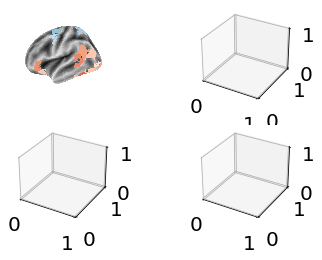

In [81]:
# surface plots
vmin,vmax = -.72,.72
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'ALL MOVIES'

for comp in range(2):
    
    nodes = np.zeros((268,))
    if comp == 0:    
        #txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        #nodes[nodes_all_SUNS_UNSNS_unc_ALLEXCEPT] = coef_soc_uns[nodes_all_SUNS_UNSNS_unc_ALLEXCEPT] # nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)
        nodes[nodes_all_SUNS_UNSNS_ALL] = coef_soc_uns_ALL[nodes_all_SUNS_UNSNS_ALL] # nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    else:
        #txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        nodes[nodes_all_SUNS_UNSNS_ALL] = coef_uns_nonsoc_ALL[nodes_all_SUNS_UNSNS_ALL]# nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
    surf_plot1(fig,ax,nodes,params)
    plt.savefig(os.path.join(fig_save_loc,f'ALL/surf_all4_{comp_lbls[comp]}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
        
    img = roi_to_brain(pd.Series(nodes), mask_x)
    #coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    #ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold')
    #ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    plt.savefig(os.path.join(fig_save_loc,f'ALL/{comp_lbls[comp]}_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

In [49]:
common_nodes_soc_uns_nonsoc_nosig

NameError: name 'common_nodes_soc_uns_nonsoc_nosig' is not defined

## (3) ALL OTHER MOVIES

In [300]:
title_txt = 'ALL OTHER MOVIES'
print('All movies: S v Unsure:',min(coef_soc_uns),max(coef_soc_uns))
print('All movies: Unsure v BS:',min(coef_uns_nonsoc),max(coef_uns_nonsoc))


All movies: S v Unsure: -0.31242009050342556 0.7199556339499221
All movies: Unsure v BS: -0.266758698360369 0.40560446426296987


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


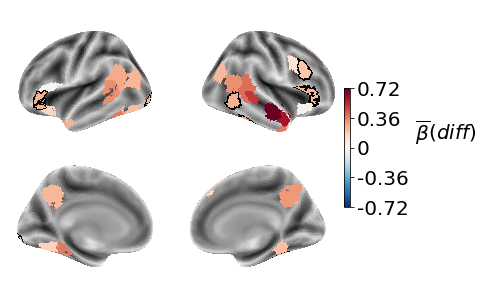

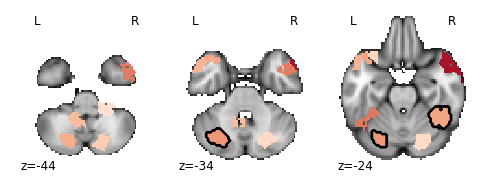

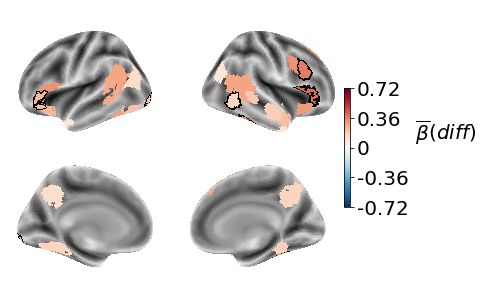

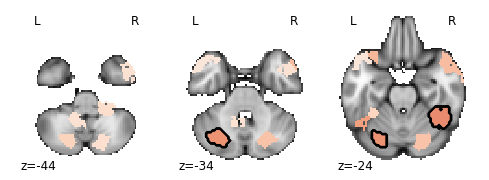

In [301]:
# surface plots
vmin,vmax = -.72,.72
cmap = 'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'ALL OTHER MOVIES'

for comp in range(2):
    
    nodes = np.zeros((268,))
    if comp == 0:    
        #txt = '  'r"$\overline{\beta}{(''Social'')}-$" + '\n  ' + r"$\overline{\beta}{(''Unsure'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        #nodes[nodes_all_SUNS_UNSNS_unc_ALLEXCEPT] = coef_soc_uns[nodes_all_SUNS_UNSNS_unc_ALLEXCEPT] # nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)
        nodes[all_except_nosig] = coef_soc_uns[all_except_nosig] # nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    else:
        #txt = '  'r"$\overline{\beta}{(''Unsure'')}-$" + '\n  ' + r"$\overline{\beta}{(''Non-social'')}$"
        txt = '  'r"$\overline{\beta}{(diff)}$"
        nodes[all_except_nosig] = coef_uns_nonsoc[all_except_nosig]# nodes to be colored - those that show a social > unsure > NS for all movies (across rand and all othrs will be contoured)

    fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
    params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
    surf_plot1(fig,ax,nodes,params)
    plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/surf_all4_{comp_lbls[comp]}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
        
    img = roi_to_brain(pd.Series(nodes), mask_x)
    #coords = [-50,-40,-30,-20,-10,0,10,25,40,50,60] # initial exploration
    coords = [-44,-34,-24] # initial exploration
    ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = .0001)
    #ax_plot.title(title_txt,fontsize=24,bgcolor='k',color='w',fontweight='bold') 
    #ax_plot._colorbar_ax.text(1,.8*vmax,txt,fontsize=20,fontdict = {'verticalalignment':'top','rotation':0})#get_legend()
    ax_plot.add_contours(color_rois(common_nodes_soc_uns_nonsoc_nosig),linewidths=1, colors=['k'],linestyles ='-',filled=False)
    plt.savefig(os.path.join(fig_save_loc,f'ALL_OTHERS/{comp_lbls[comp]}_axial.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    #plt.clf()

## Correlation plots

In [83]:
# correlation plots

def plot_fig(X,Y,xlabel,ylabel,xymin,xymax):
    plt.plot(X,Y,ls='None',marker='.',alpha = .5,color='grey',label = 'mean diff. per node',markersize=8)
    r,p = stats.pearsonr(X,Y)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
   
    plt.xlim(xymin,xymax)
    plt.ylim(xymin,xymax)

    xpos = xymin+ .05*(xymax-xymin)
    ypos = xymin+ .8*(xymax-xymin)
    plt.text(xpos,ypos,f'r={r:.2f},\np={p:.1e}',fontsize=20)

    m, b = np.polyfit(X,Y, 1)
    print(np.poly1d([m,b]))
    xplot = np.linspace(xymin,xymax,10)
    plt.plot(xplot, m*xplot + b,ls='dashed',color = 'k',label = 'line of best fit\n(all nodes)')
    
    plt.vlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
    plt.hlines(0,xymin,xymax,color = 'grey',ls = 'dashed',alpha = .4)
   

def plot_sig_nodes(X,Y,inds):
    plt.plot(X[inds],Y[inds],ls='None',marker='+',
    mfc='k', mec='k',mew = 3, linewidth = 5,label = 'sig. across both axes',ms=12)


 
0.09687 x + 0.009471


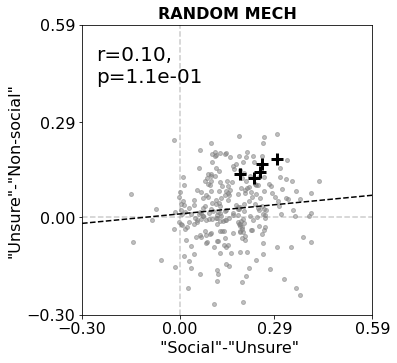

In [85]:
# CHECK THIS CELL AGAIN BEFORE RUNNING NEXT!!!!!!!

dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.59
    
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = meanDiff_sl_rand_S_UNS,meanDiff_sl_rand_UNS_NS
plot_fig(X,Y,' "Social"-"Unsure"', '"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_rand_SUNS_UNSNS_unc],Y[nodes_rand_SUNS_UNSNS_unc],mec='k',marker='o',mfc='none',ls='None')
#plt.title('RANDOM MECH')
#plt.legend(bbox_to_anchor = (1,1),fontsize =16)
plt.title('RANDOM MECH',fontweight='bold')

plt.xticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(xymin*10,xymax*10,4)/10])

plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,'RAND/rand_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')


## All movies, plot scatterplot and brainmaps : S > Unsure > NS

 
0.1279 x + 0.05142


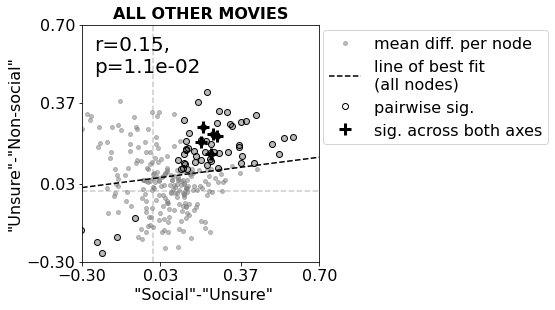

In [86]:
# scatterplot
dims = [12,9.6]
fig= plt.figure(1,figsize = dims)

xymin,xymax = -.3,.7
#plt.suptitle('Mean differences: "Social" - "Nonsocial"',fontweight='bold')
ax = fig.add_subplot(221)
X,Y = coef_soc_uns,coef_uns_nonsoc
plot_fig(X,Y,' "Social"-"Unsure"','"Unsure"-"Non-social"',xymin,xymax)
ax.set_aspect('equal')
#signodes
plt.plot(X[nodes_all_SUNS_UNSNS_ALLEXCEPT],Y[nodes_all_SUNS_UNSNS_ALLEXCEPT],mec='k',marker='o',mfc='none',markersize=6,ls='None',label = 'pairwise sig.')
plot_sig_nodes(X,Y,common_nodes_soc_uns_nonsoc)
#plt.plot(X[nodes_all_SUNS_UNSNS_ALLEXCEPT],Y[nodes_all_SUNS_UNSNS_ALLEXCEPT],mec='k',marker='o',mfc='none',ls='None')
plt.title('ALL OTHER MOVIES',fontweight='bold')
plt.legend(bbox_to_anchor = (2,1.01),fontsize =16)
plt.xlim(xymin,xymax)
plt.ylim(xymin,xymax)
plt.xticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.yticks([np.round(i,2) for i in np.linspace(-3,7,4)/10])
plt.savefig(os.path.join(fig_save_loc,'ALL_OTHERS/all_soc_v_unsure_v_nonsoc_scatterplots.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')




# extra


In [ ]:
# check only if needed, this takes time!
# soc vs. nonsocial- - other 9 movies. 
if load_allexcept == 1:
     [coef_soc_nonsoc,pval_soc_nonsoc] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_othermovies.npy'), allow_pickle=True)
else:
    start_time =  time.time()

    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        df = pd.DataFrame(columns = ['coefs','response','subID','movie'])
        for m in other_movies:
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'response':responses[subs_10resp,m], 'subID':subs_10resp, 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 9] # yes v no
        
        df['response'] = df['response'].map({0.0: "Non-social", 1.0:  "Social"})
        model = Lmer('coefs ~  response +(1|subID)', data=df) # ff: mean response, rf:subjID
        model.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)
        if n == 0:
            print(model.fit(factors={"response":["Non-social","Social"]}))
    
        #model.fit(summary = False, verbose = False)
        coef_soc_nonsoc[n] = model.coefs['Estimate'][1]
        pval_soc_nonsoc[n]= model.coefs['P-val'][1]

    np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','lmecoefs_all_soc_v_nonsoc_othermovies.npy'),[coef_soc_nonsoc,pval_soc_nonsoc])
    print('Done on/at:',datetime.now()) # cell run at)

In [116]:
fig_save_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig4_soc_unsure_nonsoc_figs3,4/unsure_analyses/'

In [118]:
print(min(meanDiff_sl_rand_unsure_sure),max(meanDiff_sl_rand_unsure_sure))
print(min(coef_unsure_sure),max(coef_unsure_sure))

-0.2556920696778834 0.20894016749339722
-0.34809065043255083 0.29865647724689826
